# Overview

## Objective

## Data Description

## Import Libraries

In [257]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [258]:
# set the base directory for the data
base_dir = os.path.expanduser("~/projects/flatiron_p4/capstone/data/chest_xray")

# set the training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Seeding
To ensure consistent results across all experiments, we will set a seed for the random number generator.

In [259]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## Data Preparation

- Use ImageDataGenerator to read images from directories, convert them into floating-point tensors, and apply generalization.
- Normalize pixel values to be in the [0, 1] range.
- Reduce overfitting by using data augmentation (Generalization)
    - Prevents overfitting (since CNNs can memorize training images).
    - Simulates real-world variations like small rotations or shifts.
    - Helps the model generalize better to unseen images.

In [260]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Load Data
- Load the dataset using the flow_from_directory method.
- Our dataset is already divided into training and validation sets.
- The dataset contains 2 classes: `NORMAL` and `PNEUMONIA`.
    - /train directory is used for training the model.
    - /val directory is used for validating the model.
    - /test directory is used for testing the model.

### **IMG_SIZE** and **BAT_SIZE**
- X-ray images come in different resolutions.
- CNNs require a fixed input size.
- Downsampling to 150x150 balances computational cost and image detail.

In [261]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

### Load Data

In [262]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    # important for evaluation
    shuffle=False  
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Sanity Check
- Ensure that the data is loaded correctly
- Check class names
- Check class distribution
- Visualize a few of the images in the dataset

In [263]:
# Check class names (should be ["NORMAL", "PNEUMONIA"])
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


In [264]:
# print the distribution of the data
print("Training Data")
print("Normal: ", len(os.listdir(os.path.join(train_dir, 'NORMAL'))))
print("Pneumonia: ", len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))

Training Data
Normal:  1342
Pneumonia:  3876


Note that the dataset is imbalanced, with more pneumonia cases than normal cases.

## Model Architecture

We will use a Convolutional Neural Network (CNN) to classify the images. A Convolutional Neural Network (CNN) is ideal for image classification because it extracts features (like edges, textures, and shapes) using convolutional layers. 

### Model Definition

We will leverage a moderate CNN with the following layers:

- `Conv2D` -- Convolutional Layers 
    - Detects patterns like edges, textures, and shapes.
    - Uses small filters (kernels) (e.g., 3x3) to scan the image.
    - Activation function: ReLU (Rectified Linear Unit) (removes negative values to introduce non-linearity).

- `MaxPooling2D` -- Pooling Layers
    - Reduces spatial size while keeping important features.
    - Helps prevent overfitting and improves computational efficiency.
    - Common choice: MaxPooling (2x2).

- `Dropout` Layers
    - Randomly turns off neurons during training.
    - Helps prevent overfitting by forcing the model to generalize.

- `Dense` Fully Connected Layers
    - Takes extracted features and makes predictions.
    - Last layer uses Softmax (for multi-class classification) or Sigmoid (for binary classification).

- `Flatten` Layer
    - Converts the 2D matrix data to a vector.

- `relu` Activation Function
    - Introduces non-linearity.
    - Helps the model learn complex patterns.

- `sigmoid` activation function
    - Used in the output layer for binary classification.

In [265]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid') 
])

### Model Compilation
- Loss Function: Binary Crossentropy
The loss function tells the model how far its predictions are from the correct labels and guides weight updates. We use binary crossentropy for binary classification problems.

- Optimizer: Adam
The optimizer controls how the model updates its weights during training.
We use Adam (Adaptive Moment Estimation) because it automatically adjusts learning rates for each parameter, speeding up convergence.

- Metrics: Accuracy, Precision, Recall, AUC
    - Accuracy is simple and intuitive: it tells us what percentage of predictions are correct.
    - Precision tells us what percentage of positive predictions were correct.
    - Recall tells us what percentage of actual positives were correctly predicted.
    - AUC (Area Under the Curve) is the area under the ROC curve and tells us how well the model is distinguishing between classes.

In [266]:
# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()],
    )

model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
We add early stopping to prevent overfitting and reduce learning rate on plateau:

In [267]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - accuracy: 0.7465 - auc_17: 0.6118 - loss: 0.6372 - precision_16: 0.7471 - recall_16: 0.9967 - val_accuracy: 0.6250 - val_auc_17: 0.8203 - val_loss: 1.2383 - val_precision_16: 0.5714 - val_recall_16: 1.0000 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.8451 - auc_17: 0.9067 - loss: 0.3448 - precision_16: 0.8788 - recall_16: 0.9197 - val_accuracy: 0.6250 - val_auc_17: 0.8438 - val_loss: 1.2413 - val_precision_16: 0.5714 - val_recall_16: 1.0000 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - accuracy: 0.8617 - auc_17: 0.9199 - loss: 0.3261 - precision_16: 0.9023 - recall_16: 0.9131 - val_accuracy: 0.6250 - val_auc_17: 0.8828 - val_loss: 1.0553 - val_precision_16: 0.5714 - val_recall_16: 1.0000 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.8642 - auc_17: 0.9215 - loss: 0.3302 - precision_16: 0.9091 - recall_1

## Model Evaluation
- We will evaluate the model on the test set using metrics like accuracy, precision, recall, and AUC.
- We will also visualize the confusion matrix to see how well the model is predicting each class.

### Classification Report

In [274]:
# classifcation metrics
loss, accuracy, precision, recall, auc = model.evaluate(test_generator)
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test recall:", recall)
print("Test AUC:", auc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8712 - auc_17: 0.6036 - loss: 0.5536 - precision_16: 0.5383 - recall_16: 0.5705
Test accuracy: 0.8605769276618958
Test precision: 0.9173553586006165
Test recall: 0.8538461327552795
Test AUC: 0.9024051427841187


### Making Predictions

In [269]:
y_true = test_generator.classes
y_pred = model.predict(test_generator).flatten().round()

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


### Classification Report

In [270]:
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.78      0.87      0.82       234
   PNEUMONIA       0.92      0.85      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.87      0.86      0.86       624



### Confusion Matrix

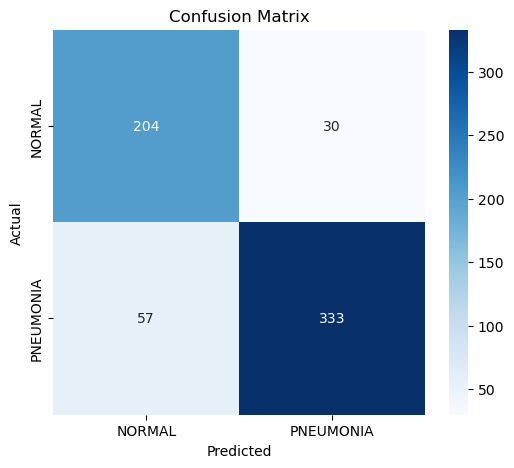

In [271]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Training vs. Validation Accuracy

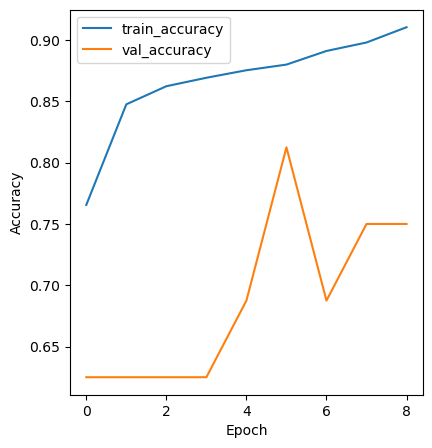

In [272]:
# plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

### Training vs. Validation Loss

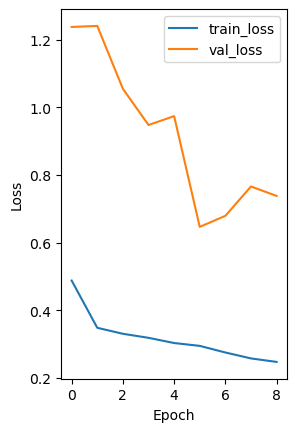

In [273]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation Results

1. Overall
    - The model achieves an accuracy of 86% with a higher precision for `Pneumonia` (0.92) than `Normal` (0.78).
    - Recall for `Pneumonia` (0.85) is lower than precision, indicating that the model misses some pneumonia cases.
2. Signs of Overfitting 
    - Training accuracy is significantly higher than validation accuracy.
    - Training loss is lower than validation loss.
3. Class Imbalance
    - There are more `Pneumonia` (390) cases than `Normal` (234) cases.
    - The model performs better on the majority class (`Pneumonia`) than the minority class (`Normal`) suggested by the higher recall and precision for `Pneumonia`.
4. Strong class discrimination (AUC: 0.90)    

## Tuning Hyperparameters

### Class Weights

- Assign higher weights to underrepresented classes to balance the loss function.
- This helps the model pay more attention to minority classes.

In [ ]:
train_labels = train_generator.classes

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

model.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weight_dict)


### Early Stopping
- Stops training if validation loss does not improve for 3 epochs, preventing overfitting.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stopping])